# Importar Librarias y datos

In [411]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np   
import itertools
import statsmodels.formula.api as smf 
import tensorflow as tf
from scipy.stats import chi2_contingency, ttest_ind
from statsmodels.stats.outliers_influence import variance_inflation_factor
from tensorflow import keras
from tensorflow.keras import layers
from keras.optimizers import SGD 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import roc_curve

In [236]:
df_final = pd.read_parquet("output_08.parquet")

In [237]:
df_final.head()

,age,gender,employment_stat,wage_per_hour,working_week_per_year,occupation_code,total_employed,gains,losses,stocks_status,...,tax_status_Otro,tax_status_Single,citizenship_Native,citizenship_Otro,country_of_birth_own_US,migration_code_change_in_msa_MSA to MSA,migration_code_change_in_msa_Otro,migration_code_change_in_msa_unchanged,migration_code_change_in_reg_Otro,migration_code_change_in_reg_unchanged
0,0.853333,1.0,0.0,0.000000,1.000000,0.000000,0.333333,0.0,0.0,0.002916,...,True,False,True,False,True,False,False,False,False,False
1,0.666667,1.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,False,True,True,False,True,False,False,True,False,True
2,0.080000,0.0,0.0,0.050005,0.288462,0.565217,0.666667,0.0,0.0,0.000000,...,False,True,True,False,True,False,False,True,False,True
4,0.733333,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,False,False,True,False,True,False,False,False,False,False
5,0.400000,0.0,0.0,0.082508,1.000000,0.673913,1.000000,0.0,0.0,0.000000,...,False,False,False,False,False,False,False,True,False,True


# Dividir datos en test y train 75% y 25%

In [239]:
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, roc_auc_score

In [240]:
# Separar variables predictoras y objetivo
X = df_final.drop(columns=['income_above_limit'], errors='ignore')
y = df_final['income_above_limit']

In [241]:
# 1. Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,  # 25% para prueba
    stratify=y,      # Mantener la proporción de clases
    random_state=42
)

In [242]:
X_train.shape

(119860, 45)

# Corregir desbalance de los datos = SMOTE + Class Weight

In [244]:
# 2. Aplicar SMOTE solo al conjunto de entrenamiento
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [245]:
# 3. Calcular los pesos de clase
class_counts = np.bincount(y_train_resampled)  # Contar muestras por clase después de SMOTE
total_samples = class_counts.sum()
weight_for_class_0 = total_samples / (2 * class_counts[0])  # Peso para la clase mayoritaria
weight_for_class_1 = total_samples / (2 * class_counts[1])  # Peso para la clase minoritaria
class_weights = {0: weight_for_class_0, 1: weight_for_class_1}
print("Pesos de clase:", class_weights)

Pesos de clase: {0: 1.0, 1: 1.0}


# Definir Modelo de Red Neuronal

In [247]:
# Definir la arquitectura del modelo
model = Sequential()
model.add(Input(shape=(X_train_resampled.shape[1],)))  # Capa de entrada
model.add(Dense(units=128, activation='relu'))         # Primera capa oculta
model.add(Dropout(0.3))                                # Regularización
model.add(Dense(units=64, activation='relu'))          # Segunda capa oculta
model.add(Dropout(0.3))                                # Regularización
model.add(Dense(units=1, activation='sigmoid'))        # Capa de salida

In [249]:
# Compilar el modelo
model.compile(
    optimizer=Adam(learning_rate=0.001),  # Optimizador
    loss='binary_crossentropy',           # Función de pérdida
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]# Métricas
)

In [251]:
# Entrenar el modelo con Early Stopping y class_weight
early_stopping = EarlyStopping(
    monitor='val_loss',  # Métrica a monitorear
    patience=5,          # Número de épocas sin mejora antes de detener
    restore_best_weights=True  # Restaurar los mejores pesos encontrados
)

In [252]:
history = model.fit(
    X_train_resampled, y_train_resampled,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),  # Validación con datos no resampleados
    callbacks=[early_stopping],
    class_weight=class_weights  # Aplicar pesos de clase
)

Epoch 1/50
6882/6882 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - accuracy: 0.8292 - auc: 0.9068 - loss: 0.3808 - val_accuracy: 0.8454 - val_auc: 0.9165 - val_loss: 0.3216
Epoch 2/50
6882/6882 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - accuracy: 0.8626 - auc: 0.9349 - loss: 0.3189 - val_accuracy: 0.8473 - val_auc: 0.9148 - val_loss: 0.3078
Epoch 3/50
6882/6882 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - accuracy: 0.8703 - auc: 0.9403 - loss: 0.3047 - val_accuracy: 0.8337 - val_auc: 0.9149 - val_loss: 0.3431
Epoch 4/50
6882/6882 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - accuracy: 0.8733 - auc: 0.9437 - loss: 0.2964 - val_accuracy: 0.8572 - val_auc: 0.9147 - val_loss: 0.2995
Epoch 5/50
6882/6882 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - accuracy: 0.8760 - auc: 0.9452 - loss: 0.2915 - val_accuracy: 0.8524 - val_auc: 0.9169 - val_loss: 0.3116
Epoch 6/50
6882/6882 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - accuracy: 0.8776 - auc: 0.9468 - loss: 0.2875 - val_accuracy: 0.8455 - val_auc: 0.9162 - val_loss: 0.3254
Epoch 7/50
6882/6882 ━

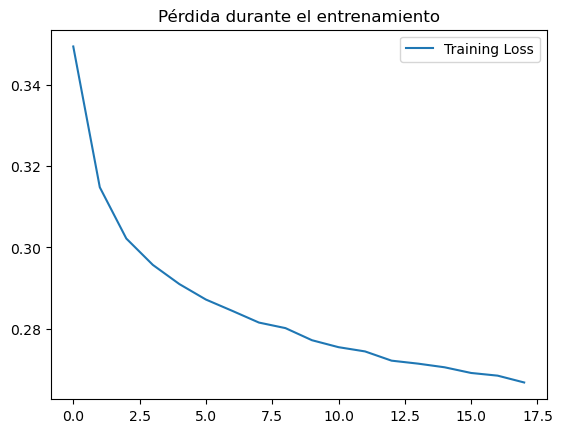

In [253]:
# Gráfico de pérdida
plt.plot(history.history['loss'], label='Training Loss')
plt.legend()
plt.title('Pérdida durante el entrenamiento')
plt.show()

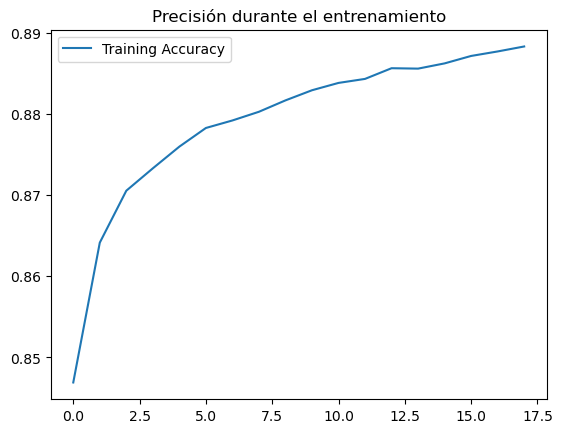

In [254]:
# Gráfico de precisión 
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.legend()
plt.title('Precisión durante el entrenamiento')
plt.show()

# Evaluación del modelo

In [255]:
results = model.evaluate(X_test, y_test)  # Devuelve [loss, accuracy, auc]

# Imprimir los resultados
print(f"Loss: {results[0]:.4f}")
print(f"Accuracy: {results[1]:.4f}")
print(f"AUC: {results[2]:.4f}")

1249/1249 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8715 - auc: 0.9152 - loss: 0.2779
Loss: 0.2770
Accuracy: 0.8726
AUC: 0.9146


In [257]:
prediccion_prob = model.predict(X_test)
prediccion = (prediccion_prob > 0.5).astype(int) # Umbral de decisión

1249/1249 ━━━━━━━━━━━━━━━━━━━━ 1s 622us/step


In [258]:
prediccion 

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [1]])

In [315]:
# Asegúrate de que todas las columnas sean unidimensionales
tabla_final = pd.DataFrame(
    {
        'X1': X_test.iloc[:, 0].values,  # Convertir a array unidimensional
        'X2': X_test.iloc[:, 1].values,  # Convertir a array unidimensional
        'Y_real': y_test.values,         # Convertir a array unidimensional
        'Y_Pred': prediccion.flatten()   # Aplanar prediccion a 1D
    }
)
tabla_final

,X1,X2,Y_real,Y_Pred
0,0.293333,1.0,0.0,0
1,0.200000,0.0,0.0,0
2,0.786667,1.0,0.0,0
3,0.413333,0.0,0.0,0
4,0.800000,0.0,0.0,0
...,...,...,...,...
39949,0.346667,1.0,0.0,0
39950,0.733333,1.0,0.0,0
39951,0.853333,0.0,0.0,0
39952,0.120000,0.0,0.0,0


In [261]:
# Métricas de evaluación
print(classification_report(y_test, prediccion))
print(f"AUC-ROC: {roc_auc_score(y_test, prediccion_prob):.4f}")

              precision    recall  f1-score   support

         0.0       0.98      0.88      0.93     36704
         1.0       0.37      0.78      0.50      3250

    accuracy                           0.87     39954
   macro avg       0.67      0.83      0.71     39954
weighted avg       0.93      0.87      0.89     39954

AUC-ROC: 0.9162


# Métricas

In [348]:
f1 = f1_score(y_test, prediccion)
auc = roc_auc_score(y_test, prediccion)
precision = precision_score(y_test, prediccion)  
recall = recall_score(y_test, prediccion) 

In [350]:
print("\nResultados de la evaluación:")
print(f"F1-score: {f1:.4f}")
print(f"AUC-ROC: {auc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")


Resultados de la evaluación:
F1-score: 0.4982
AUC-ROC: 0.8292
Precision: 0.3666
Recall: 0.7772


In [352]:
confusion_matrix(y_test, prediccion)

array([[32339,  4365],
       [  724,  2526]])

# Mejorar el recall cambiando el umbral de decisión a 0,6

In [399]:
prediccion_dos = (prediccion_prob > 0.6).astype(int)  # Umbral ajustado a 0.6

In [401]:
prediccion_dos

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [1]])

In [403]:
# Asegúrate de que todas las columnas sean unidimensionales
tabla_final_dos = pd.DataFrame(
    {
        'X1': X_test.iloc[:, 0].values,  # Convertir a array unidimensional
        'X2': X_test.iloc[:, 1].values,  # Convertir a array unidimensional
        'Y_real': y_test.values,         # Convertir a array unidimensional
        'Y_Pred': prediccion_dos.flatten()   # Aplanar prediccion a 1D
    }
)
tabla_final_dos

,X1,X2,Y_real,Y_Pred
0,0.293333,1.0,0.0,0
1,0.200000,0.0,0.0,0
2,0.786667,1.0,0.0,0
3,0.413333,0.0,0.0,0
4,0.800000,0.0,0.0,0
...,...,...,...,...
39949,0.346667,1.0,0.0,0
39950,0.733333,1.0,0.0,0
39951,0.853333,0.0,0.0,0
39952,0.120000,0.0,0.0,0


In [409]:
confusion_matrix(y_test, prediccion_dos)

array([[33316,  3388],
       [  905,  2345]])

In [405]:
precision_score(y_test, prediccion_dos)

0.409035409035409

In [407]:
f1 = f1_score(y_test, prediccion_dos)
auc = roc_auc_score(y_test, prediccion_dos)
precision = precision_score(y_test, prediccion_dos)  
recall = recall_score(y_test, prediccion_dos) 

print("\nResultados de la evaluación:")
print(f"F1-score: {f1:.4f}")
print(f"AUC-ROC: {auc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")


Resultados de la evaluación:
F1-score: 0.5221
AUC-ROC: 0.8146
Precision: 0.4090
Recall: 0.7215


# Curva ROC

1249/1249 ━━━━━━━━━━━━━━━━━━━━ 1s 581us/step


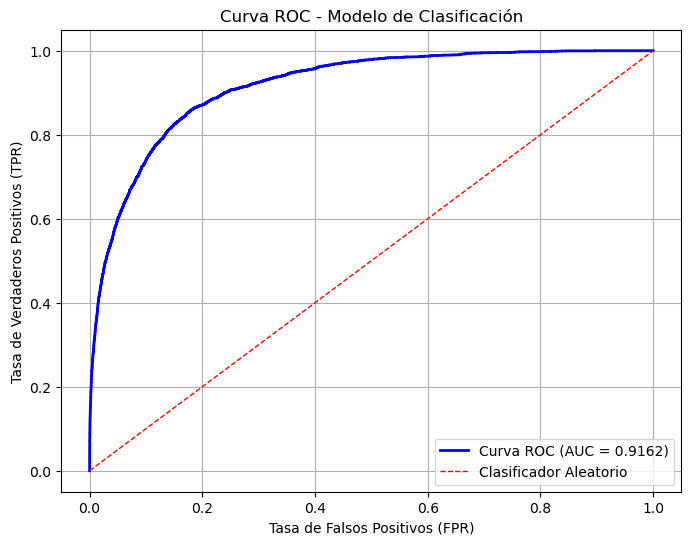

In [413]:
# 1. Calcular las probabilidades predichas (clase positiva "Above limit")
prediccion_prob = model.predict(X_test)  # Asegúrate de que sean probabilidades

# 2. Calcular FPR, TPR y thresholds para la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, prediccion_prob)

# 3. Calcular el AUC-ROC
auc = roc_auc_score(y_test, prediccion_prob)

# 4. Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Curva ROC (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], color='red', lw=1, linestyle='--', label='Clasificador Aleatorio')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC - Modelo de Clasificación')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [423]:
print(f"AUC-ROC: {auc:.4f}")

AUC-ROC: 0.9162


# Conclusiones

### Qué significa para tu modelo?

- Alta capacidad discriminativa: El modelo es muy bueno separando casos positivos y negativos.

Trade-off TPR vs. FPR:
- Si ajustas el umbral de decisión, puedes priorizar:
- Recall alto (TPR alto): Detectar más casos positivos, pero con más falsos positivos.
- Precisión alta (FPR bajo): Minimizar falsos positivos, pero detectando menos casos positivos.

### Limitaciones a considerar

- Desbalanceo de clases: Aunque el AUC es alto, **si tu dataset está desbalanceado (pocos casos positivos), métricas como precisión o F1-score pueden ser más relevantes**.
- Contexto del problema: Si los falsos positivos son costosos (ej.: diagnóstico médico), prioriza umbrales altos. Si los falsos negativos son críticos (ej.: detección de fraude), prioriza umbrales bajos.

### 1. Aspectos Positivos:

- **Recall (Sensibilidad) Alto (0.7215)**: El modelo tiene una **buena capacidad para identificar correctamente los casos positivos** (clase minoritaria). Esto es crucial en aplicaciones donde es importante detectar la mayor cantidad posible de casos positivos, como en diagnósticos médicos o detección de fraudes.
- **AUC-ROC Alto (0.8146)**: El área bajo la curva ROC indica que **el modelo tiene una buena capacidad para distinguir entre las clases positiva y negativa**. Un AUC de 0.8146 es considerado muy bueno y sugiere que el modelo tiene un rendimiento sólido en términos de clasificación.

### 2. Aspectos Negativos:

- **Precisión Baja (0.4090)**: Aunque el modelo tiene un buen recall, la precisión es relativamente baja. Esto significa que hay un número significativo de falsos positivos, lo que puede ser problemático en aplicaciones donde los falsos positivos tienen un alto costo, como en marketing dirigido o diagnósticos médicos.
- **F1-score Moderado (0.5221)**: El F1-score, que es la media armónica de precisión y recall, es moderado. Esto indica que hay un equilibrio entre precisión y recall, pero no es óptimo. El modelo podría mejorar en términos de equilibrio entre detectar casos positivos y minimizar falsos positivos.

### 3. Mejoras Potenciales:

- **Optimización del Umbral de Decisión**: Ajustar el umbral de decisión podría ayudar a mejorar la precisión o el recall, dependiendo de las necesidades específicas del problema. Por ejemplo, aumentar el umbral podría reducir los falsos positivos y mejorar la precisión, aunque esto podría disminuir el recall.
- **Manejo del Desbalanceo**: Aunque ya has utilizado técnicas como SMOTE y class_weight, podrías explorar otras técnicas de balanceo de datos o algoritmos más robustos para manejar el desbalanceo, como XGBoost o LightGBM, que suelen funcionar bien en estos casos.
- **Feature Engineering**: Revisar y mejorar las características utilizadas en el modelo podría ayudar a mejorar tanto la precisión como el recall. Esto podría incluir la eliminación de características irrelevantes o la creación de nuevas características que capturen mejor la información relevante.

En resumen, tu modelo tiene un buen rendimiento en términos de recall y AUC-ROC, pero hay margen de mejora en la precisión y el equilibrio general entre precisión y recall. Ajustar el umbral de decisión y explorar otras técnicas de manejo de desbalanceo y feature engineering podrían ayudar a mejorar aún más el rendimiento del modelo.

En los casos en los que hay **mucho desbalance de datos**, el modelo de **red neuronal no es el más recomendado de utilizar**. 